### **Notebook description**

This notebook allows you to visualize predicted damage masks and pixelwise estimated F1 scores for a dataset stored as tensor (output of "get_tensors_pre_post.ipynb").

It uses the Segformer pre-trained semantic segmentation model contained in "stepwise_model_classification.ipynb" and saved in the folder named as the variable "name_model" (see below).

The path to the data tensor is defined in the variable "path_dataset", see below.

In [1]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [5]:
# path to dataset tensor post-disaster 
path_dataset="../data/tensors_post_xBD_last_subset.npz"

# name folder (located here) where the segformer model is saved
name_model="classification_model_test1"


In [6]:
# LOADING TENSORS
loaded_arrays_post = np.load(path_dataset)


In [7]:
# Load the saved model from the directory defined in the variable "name_model"

from transformers import TFSegformerForSemanticSegmentation

loaded_model =  TFSegformerForSemanticSegmentation.from_pretrained(name_model, local_files_only=True)

/Users/gmeneses/DScourse/00_capstone/Capstone_Building_Damage/notebooks/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-21 11:02:04.328485: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2873c2780 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-08-21 11:02:04.328645: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-08-21 11:02:04.439546: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at classification_model_test1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


In [8]:
# getting images and masks from post tensors

images_post = loaded_arrays_post['images']
masks_post = loaded_arrays_post['masks']
id_post = loaded_arrays_post['id'] # file names for each image-mask pair


In [9]:
X = images_post
y = masks_post

print(len(X), len(y)) 
print (X[0].shape)
print (y[0].shape)
print(id_post.shape)

1353 1353
(1024, 1024, 3)
(1024, 1024, 1)
(1353,)


In [10]:
# SPLITTING (same random state used while training the data (stepwise_model_classification.ipynb))
train_X, val_X,train_y, val_y= train_test_split(X, y, test_size=0.2, 
                                                      random_state=0
                                                     )

In [11]:

# develop tf Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_X,train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_X,val_y))

# verify the shapes and data types
train_dataset.element_spec, val_dataset.element_spec
print(len(train_dataset))
print(len(val_dataset))


1082
271


## Function definitions

In [12]:
def map_fn(image, mask):
    # Assign names to the elements in the dataset
    return {"image": image, "segmentation_mask": mask}


In [13]:
# here we could try with nearest instead bilinear
# to solve the problem of getting pixels with categories
# that do not exist after resizing
from tensorflow.keras import backend

image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])


def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    #input_mask -= 1
    return input_image, input_mask


def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )
    
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}    

In [14]:
import matplotlib.pyplot as plt

def convert_mask_to_3_channels(mask_1_channel):
    """convert 1 channel mask (numpy array) in 3 channel mask, preserving labels 
    defined in "category_colors" dictionary
    
    Args:
        mask (~numpy.ndarray): A mask array with 1 dimension.
        
    Returns:
        mask (~numpy.ndarray) with 3 channels.
    """
    # Assuming mask_1_channels has shape (height, width, 1)
    height, width, _ = mask_1_channel.shape

    # Create an empty array with shape (height, width, 1) for the single-channel mask
    deep_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Define the colors representing each category (RGB values)
    category_colors = {
        0:(0, 0, 0),        # Class 0 - Black (no building) or un-classified
        1:(255, 255, 255),  # Class 1 - White (no-damage)
        2:(255,255,0),     # Class 2 - Yellow (minor damage)
        3:(255,165,0),     # Class 3 - Orange (major damage)
        4:(255, 0, 0),     # Class 4 - Red (destroyed)
    }
    # Loop through each pixel and assign the corresponding category to the single-channel mask
    for y in range(height):
        for x in range(width):
            pixel_color = mask_1_channel[y, x, 0]
            category = category_colors.get(pixel_color, (-1,-1,-1))  # -1 for unknown category
            deep_mask[y, x] = category

    return deep_mask

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    # Create the folder if it doesn't exist
    plt.show()


In [15]:
def create_mask_single(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=0)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask

### Pre-processing data (correct input for the model)

In [16]:
named_dataset_train = train_dataset.map(map_fn)
named_dataset_val = val_dataset.map(map_fn)

In [17]:
auto = tf.data.AUTOTUNE
batch_size = 4

train = (
    named_dataset_train
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)
val = (
    named_dataset_val
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

## Predictions and model performance evaluation (F1 scores per pixel)

In [18]:
# # Use the loaded model to make predictions on new data
predictions = loaded_model.predict(val)  


68/68 [==============================] - 113s 2s/step


In [19]:
from sklearn.metrics import f1_score

def count_pixel_categories(flat_array):
    """
    Calculates how many pixels are in each class of a mask.
    :param flatarray: Flattened array of a mask containing different classes
    :returns: Dictionary containing number of pixels per class.
    """
    categories_per_pixel = {}
    for cat in flat_array:
        if cat in categories_per_pixel:
            categories_per_pixel[cat] += 1
        else:
            categories_per_pixel[cat] = 1
    return categories_per_pixel


def calc_f1_score_per_class(dataset=None):
    """
    Estimates pixel-wise F1 score per category (in this case 5 damage categories).
    :param dataset: Tensorflow dataset object.
    :returns: Dictionary containing F1 score per class.
    """
    f1_per_class = {}
    n_total = 0
    if dataset:
        for sample in dataset:
            
            print("entering in loop for sample")
            #print(n_total)
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)

            #print(images.shape,masks.shape)
            pred_masks = loaded_model.predict(images).logits
            #print(pred_masks.shape)
            #print(final_pred_masks.shape)
            for i in range(0,len(images)):
                image = images[i,:,:,:]
                mask= masks[i,:,:]
                pred_mask = pred_masks[i,:,:,:]
                #print(image.shape,mask.shape,pred_mask.shape)
                final_pred_mask = create_mask_single(pred_mask)
                #print(final_pred_mask.shape)
                final_pred_mask=tf.image.resize(final_pred_mask, (512, 512), method="nearest")
                #print(mask.shape,final_pred_mask.shape)
                
                real = np.array(mask).astype(int).flatten()  # Flatten the real mask
                predicted = np.array(final_pred_mask).astype(int).flatten()  # Flatten the predicted mask
                # printing info f1 per category
                print("real classes: ",np.unique(real))
                print("predicted classes: ",np.unique(predicted))
                print("categories per pixel real image: ",count_pixel_categories(real))
                
                # Calculate the F1 score per class
                unique_labels = np.unique(np.concatenate((real, predicted)))
                print("label","f1")
                for label in unique_labels:
                    f1 = f1_score(real == label, predicted == label)
                    

                    print(label,f1)
                    f1_per_class[label] = f1_per_class.get(label, 0) + f1
                # to plot (comment the next 3 lines if you don't want to load images)
                image = tf.transpose(image, (1, 2, 0))
                mask_deep=convert_mask_to_3_channels(np.array(mask))
                pred_mask_create_3ch = convert_mask_to_3_channels(np.array(final_pred_mask))
                display([image, mask_deep, pred_mask_create_3ch])

                n_total += 1

    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(loaded_model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )

    # Calculate the average F1 score per class
    for label, f1_total in f1_per_class.items():
        f1_per_class[label] = f1_total / n_total

    return f1_per_class

entering in loop for sample
1/1 [==============================] - 3s 3s/step
real classes:  [0 1 2 3 4]
predicted classes:  [0 1]
categories per pixel real image:  {0: 262004, 1: 16, 3: 16, 4: 105, 2: 3}
label f1
0 0.9998473527144504
1 0.025
2 0.0
3 0.0
4 0.0


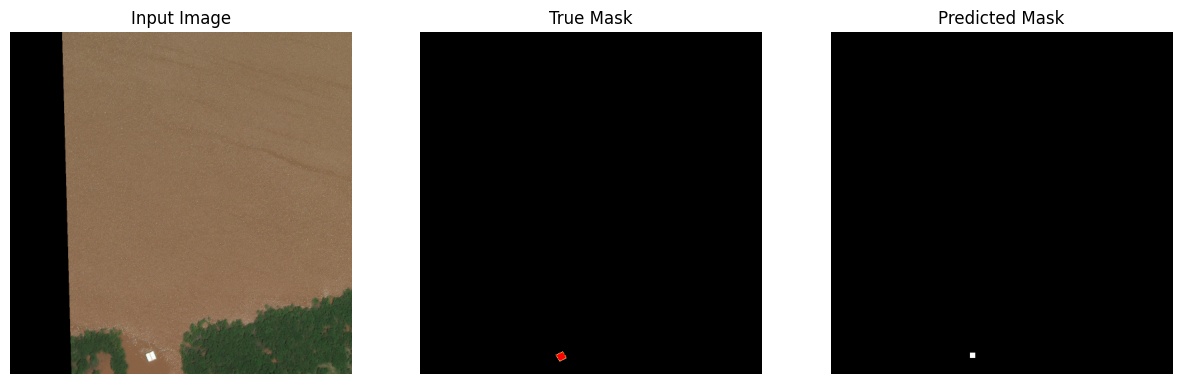

real classes:  [0 1 2 3]
predicted classes:  [0 1 3]
categories per pixel real image:  {0: 258888, 3: 2857, 1: 142, 2: 257}
label f1
0 0.9966750913097752
1 0.019978969505783387
2 0.0
3 0.08816705336426914


/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_9926/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


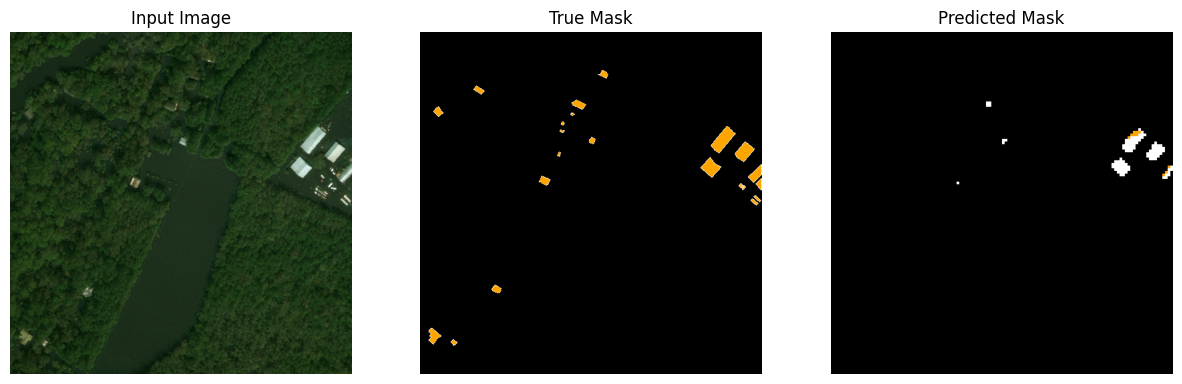

real classes:  [0 1]
predicted classes:  [0 1]
categories per pixel real image:  {0: 261692, 1: 452}
label f1
0 0.9992399880842353
1 0.3496732026143791


/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_9926/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


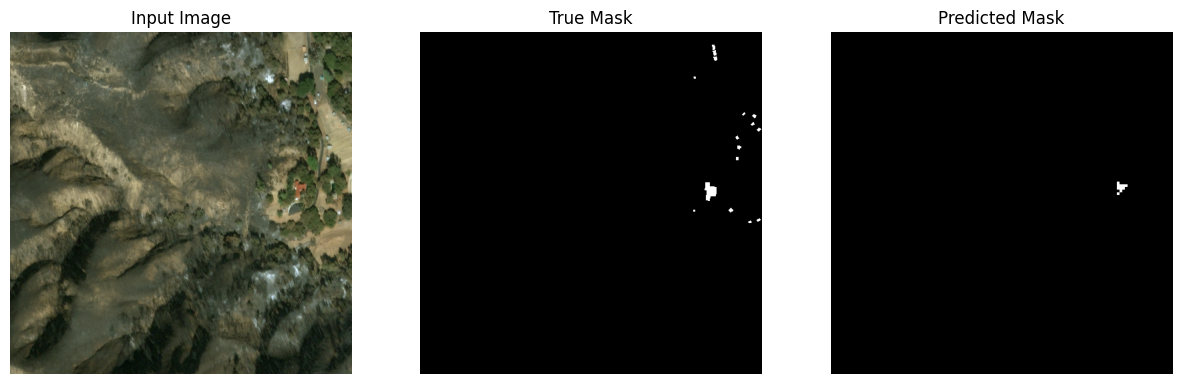

real classes:  [0 1 2 3 4]
predicted classes:  [0 1 3]
categories per pixel real image:  {0: 243702, 1: 17054, 2: 716, 3: 599, 4: 73}
label f1
0 0.975800610952641
1 0.5805479644033354
2 0.0
3 0.10200927357032458
4 0.0


/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_9926/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


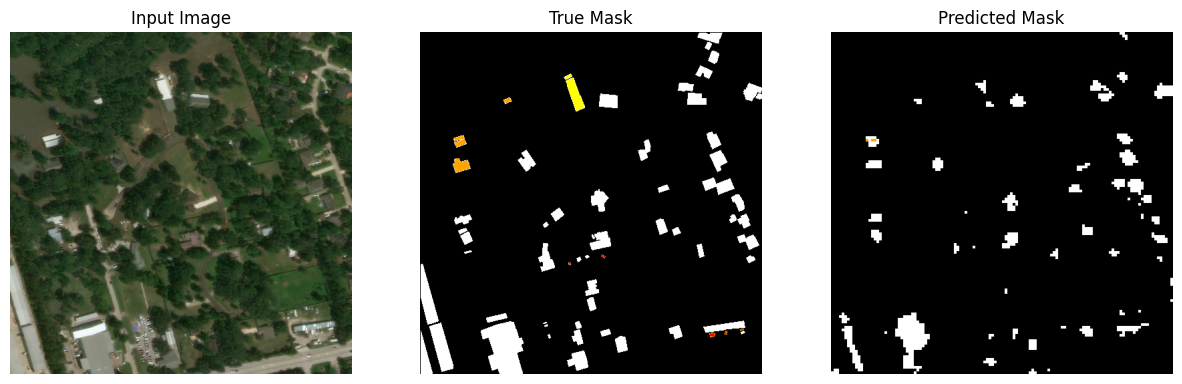

entering in loop for sample
1/1 [==============================] - 2s 2s/step
real classes:  [0 1 2 3]
predicted classes:  [0 1 3]
categories per pixel real image:  {0: 261788, 1: 35, 2: 21, 3: 300}
label f1
0 0.9996868579633548
1 0.0
2 0.0
3 0.6217391304347826


/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_9926/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


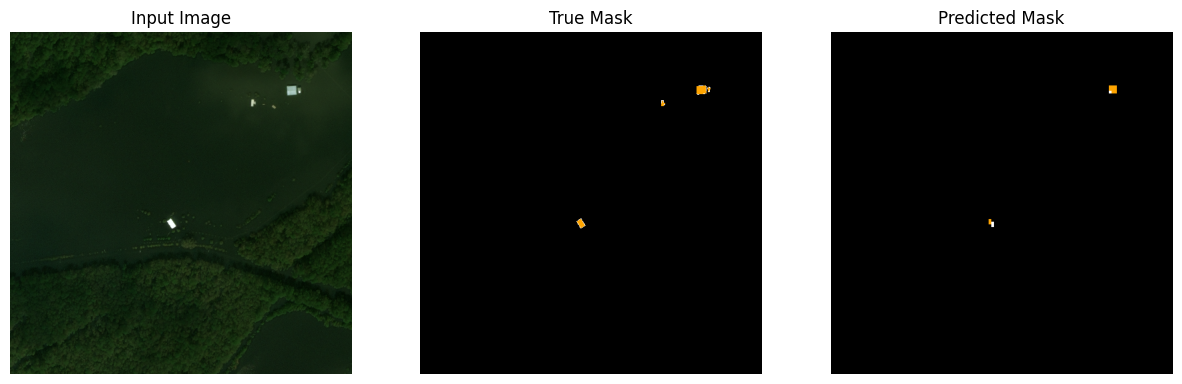

real classes:  [0 1 2 3]
predicted classes:  [0 1 3]
categories per pixel real image:  {0: 261561, 2: 22, 3: 456, 1: 105}
label f1
0 0.9991002813769706
1 0.1297297297297297
2 0.0
3 0.3287671232876712


/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_9926/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


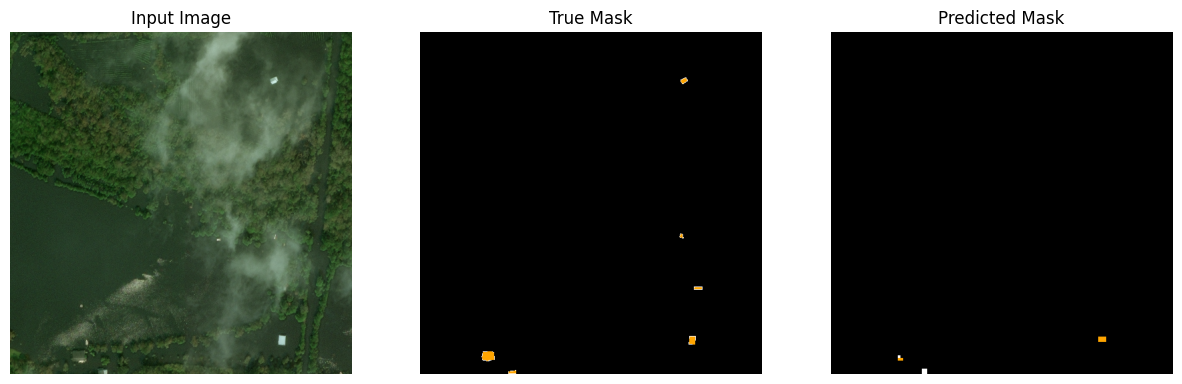

real classes:  [0 1 2 3 4]
predicted classes:  [0 1 3 4]
categories per pixel real image:  {0: 253762, 1: 4049, 3: 151, 4: 3814, 2: 368}
label f1
0 0.98536962681665
1 0.3626225725821957
2 0.0
3 0.0
4 0.06939590614078882


/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_9926/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


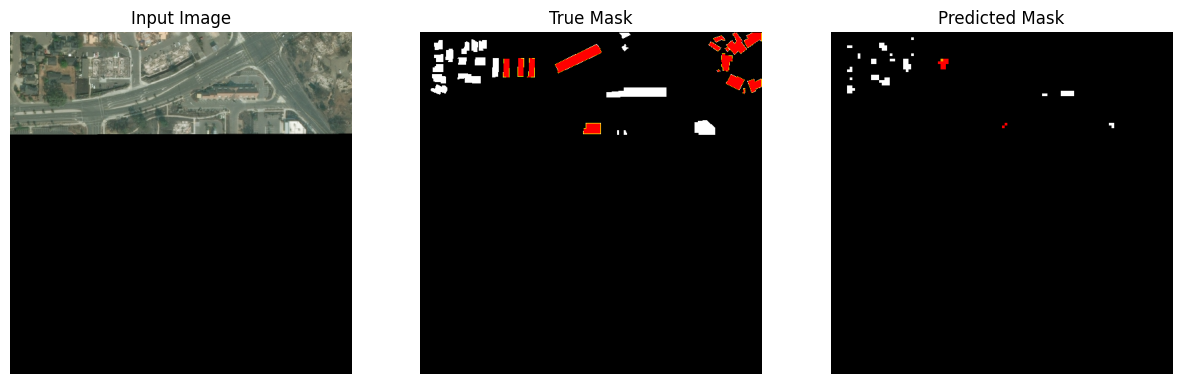

real classes:  [0 1]
predicted classes:  [0 1]
categories per pixel real image:  {0: 258881, 1: 3263}
label f1
0 0.9951964603472322
1 0.44051086712973336


/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_9926/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


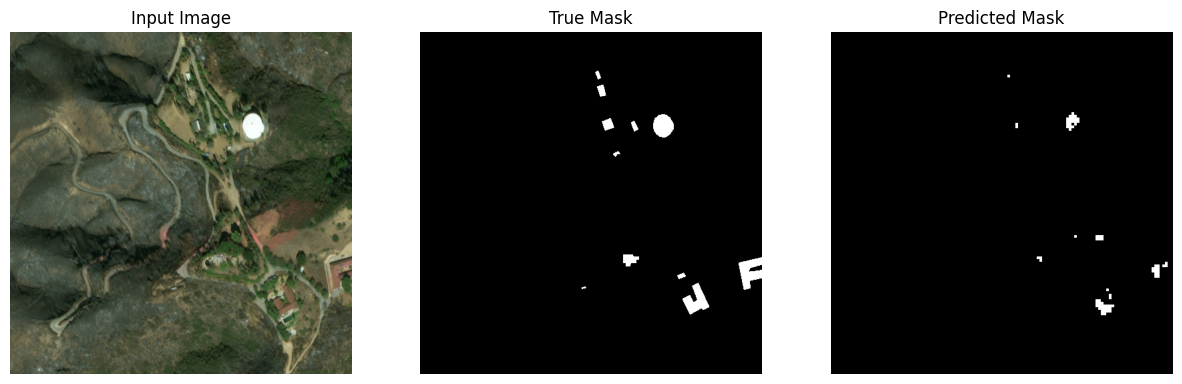

entering in loop for sample
1/1 [==============================] - 2s 2s/step
real classes:  [0 1 2 3 4]
predicted classes:  [0 1 3]
categories per pixel real image:  {0: 260520, 1: 301, 2: 1277, 3: 7, 4: 39}
label f1
0 0.9984299906336851
1 0.22660944206008585
2 0.0
3 0.0
4 0.0


/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_9926/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


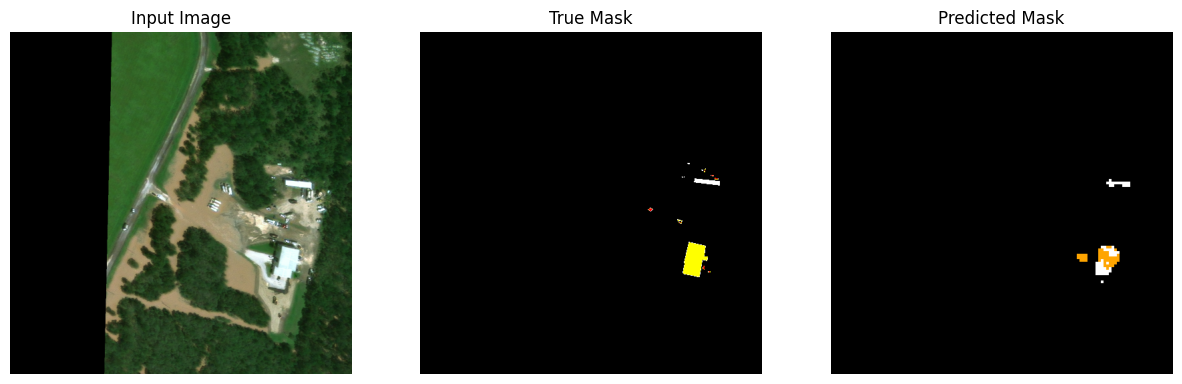

real classes:  [0 1 2 3 4]
predicted classes:  [0]
categories per pixel real image:  {0: 261026, 1: 168, 4: 423, 3: 419, 2: 108}
label f1
0 0.9978630273142574
1 0.0
2 0.0
3 0.0
4 0.0


/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_9926/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


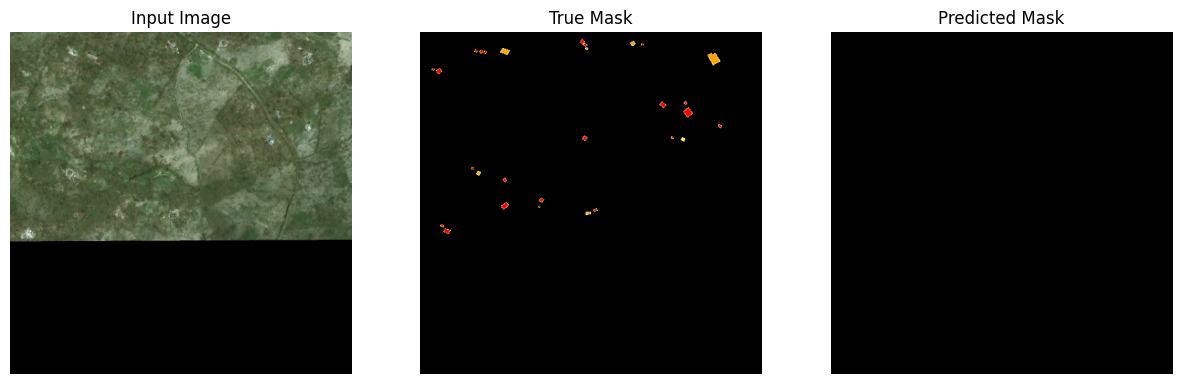

real classes:  [0 1 2]
predicted classes:  [0 1]
categories per pixel real image:  {0: 260734, 1: 1173, 2: 237}
label f1
0 0.9978447533333589
1 0.24174454828660435
2 0.0


/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_9926/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


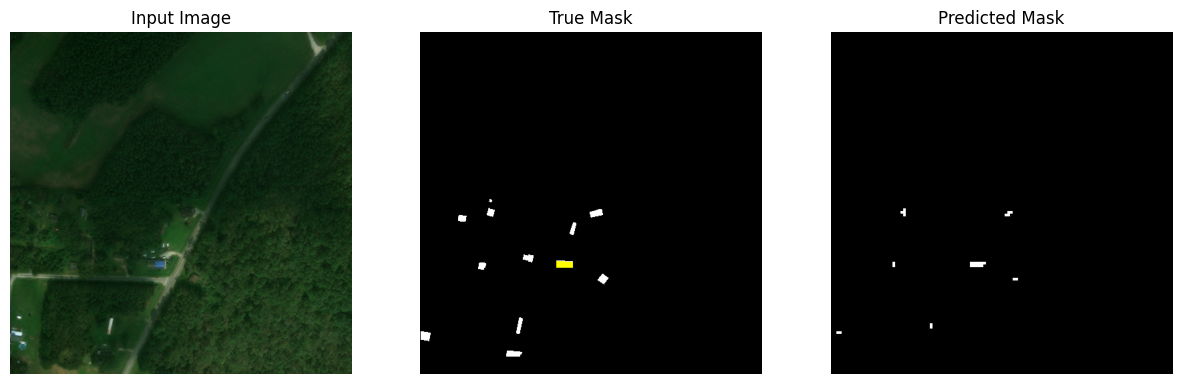

real classes:  [0 1 2 3 4]
predicted classes:  [0 1 2]
categories per pixel real image:  {0: 260946, 1: 411, 3: 51, 4: 16, 2: 720}
label f1
0 0.9971883140978314
1 0.0
2 0.0
3 0.0
4 0.0


/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_9926/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


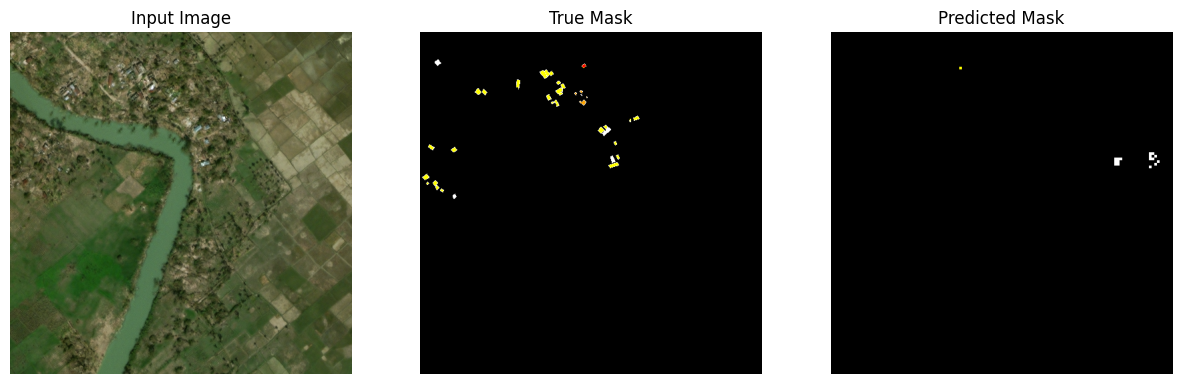

entering in loop for sample
1/1 [==============================] - 2s 2s/step
real classes:  [0 1]
predicted classes:  [0 1]
categories per pixel real image:  {0: 260227, 1: 1917}
label f1
0 0.9969697027778683
1 0.38169730152522485


/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_9926/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


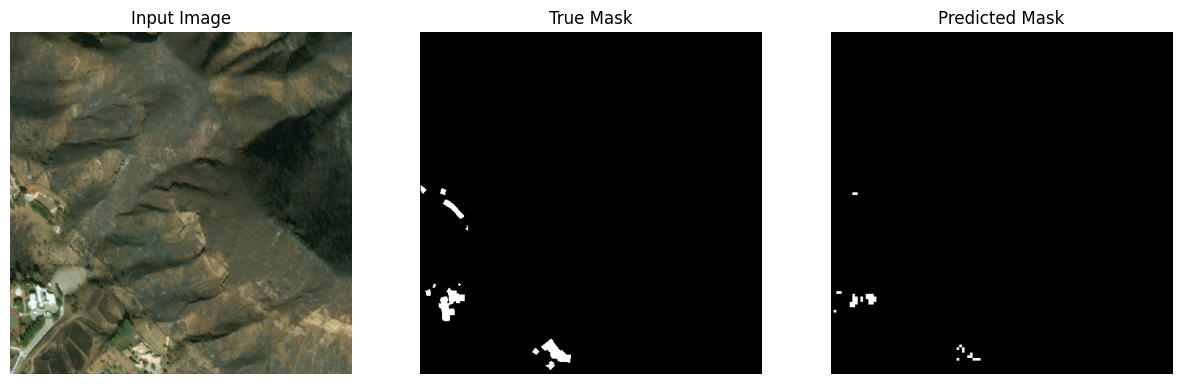

real classes:  [0 1 2 3 4]
predicted classes:  [0 1 2]
categories per pixel real image:  {0: 256301, 1: 846, 2: 3064, 3: 1302, 4: 631}
label f1
0 0.9904460880865642
1 0.138217000691085
2 0.03132992327365729
3 0.0
4 0.0


/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_9926/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


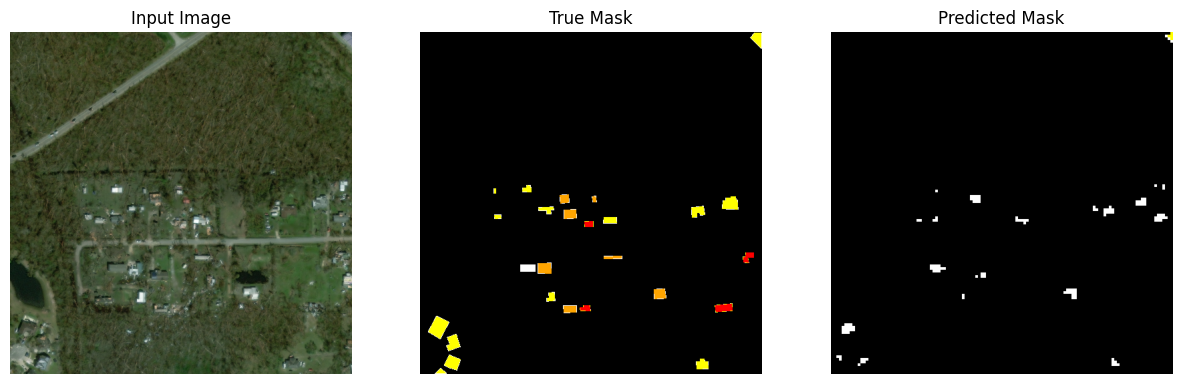

real classes:  [0 1 2 3]
predicted classes:  [0 1 2 3]
categories per pixel real image:  {0: 261341, 2: 54, 3: 723, 1: 26}
label f1
0 0.9989430367528866
1 0.017094017094017096
2 0.0
3 0.11932555123216602


/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_9926/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


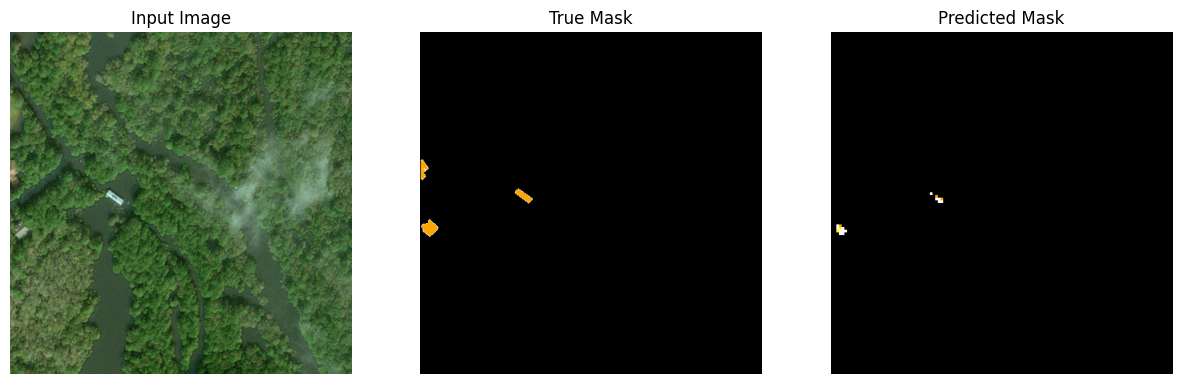

real classes:  [0 1 2 3 4]
predicted classes:  [0 1]
categories per pixel real image:  {0: 258011, 1: 2464, 2: 1368, 3: 273, 4: 28}
label f1
0 0.9933364320692163
1 0.2994186046511628
2 0.0
3 0.0
4 0.0


/var/folders/wg/xp3xzw0s1mb4zg1wgbnvpwn00000gn/T/ipykernel_9926/3995128749.py:32: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  deep_mask[y, x] = category


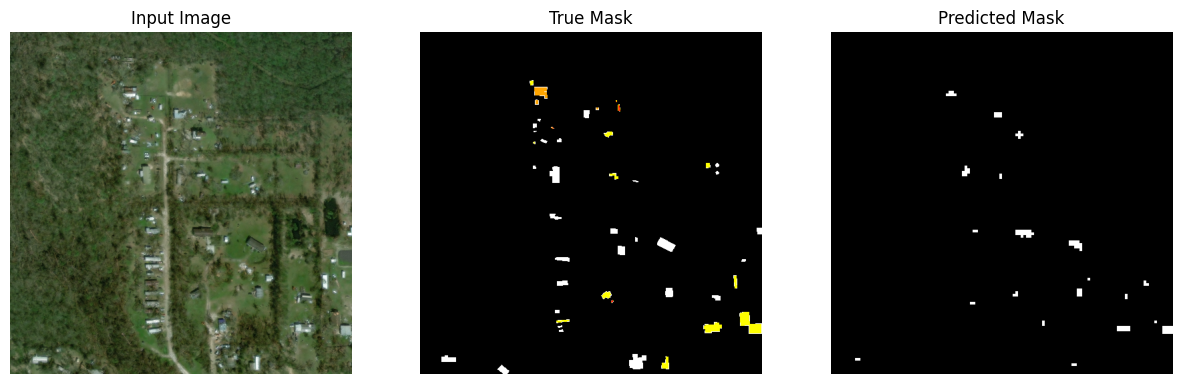

entering in loop for sample


KeyboardInterrupt: 

In [20]:
# F1 score estimation
calc_f1_score_per_class(val)

The cell above was interrupted given that the dataset was too large. If the process runs until the end, the total F1 score per category will be printed.